# Trabajo Final
## Curso: Inteligencia Artificial
## Profesor: Hugo David Calderon Vilca
## Integrantes:
* Sebastian Wilder Contreras Rosas - U20171D516
* Bill Brandon Chávez Arias - U20171042
* Carlos Vincent Tarazona Hurtado - U201712780

## Descarga del dataset

In [1]:
!gdown --id 1ex0qV-9X4XPoQcj-FIug4AXEGqTJQ4xp
!unzip datasetFinal.zip

Downloading...
From: https://drive.google.com/uc?id=1ex0qV-9X4XPoQcj-FIug4AXEGqTJQ4xp
To: /content/datasetFinal.zip
46.8MB [00:00, 68.7MB/s]
Archive:  datasetFinal.zip
  inflating: studentAssessment.csv   
  inflating: studentVle.csv          
  inflating: assessments.csv         
  inflating: courses.csv             
  inflating: studentInfo.csv         
  inflating: studentRegistration.csv  
  inflating: vle.csv                 


## Librerías

- Numpy, para el manejo de arreglos
- Pandas, para el manejo de dataframes.
- Matplotlib y seaborn, para los gráficos.
- Sklearn, para el preprocesamiento.
- Tensorflow, para la configuración de la red neuronal.

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import backend

from sklearn.preprocessing import LabelBinarizer, MinMaxScaler

## Análisis de dataset

### Lectura de los archivos .csv

In [3]:
studentInfo=pd.read_csv("studentInfo.csv")
studentInfo.head()

,code_module,code_presentation,id_student,gender,region,highest_education,imd_band,age_band,num_of_prev_attempts,studied_credits,disability,final_result
0,AAA,2013J,11391,M,East Anglian Region,HE Qualification,90-100%,55<=,0,240,N,Pass
1,AAA,2013J,28400,F,Scotland,HE Qualification,20-30%,35-55,0,60,N,Pass
2,AAA,2013J,30268,F,North Western Region,A Level or Equivalent,30-40%,35-55,0,60,Y,Withdrawn
3,AAA,2013J,31604,F,South East Region,A Level or Equivalent,50-60%,35-55,0,60,N,Pass
4,AAA,2013J,32885,F,West Midlands Region,Lower Than A Level,50-60%,0-35,0,60,N,Pass


In [4]:
assessments=pd.read_csv("assessments.csv")
assessments.head()

,code_module,code_presentation,id_assessment,assessment_type,date,weight
0,AAA,2013J,1752,TMA,19.0,10.0
1,AAA,2013J,1753,TMA,54.0,20.0
2,AAA,2013J,1754,TMA,117.0,20.0
3,AAA,2013J,1755,TMA,166.0,20.0
4,AAA,2013J,1756,TMA,215.0,30.0


In [5]:
studentAssessment=pd.read_csv("studentAssessment.csv")
studentAssessment.head()

,id_assessment,id_student,date_submitted,is_banked,score
0,1752,11391,18,0,78.0
1,1752,28400,22,0,70.0
2,1752,31604,17,0,72.0
3,1752,32885,26,0,69.0
4,1752,38053,19,0,79.0


In [6]:
studentVle=pd.read_csv("studentVle.csv")
studentVle.head()

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1


In [7]:
vle=pd.read_csv("vle.csv")
vle.head()

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN


### Obtenemos los assessments que no sean examenes y los contamos por presentación de un módulo.

In [8]:
exams = assessments[assessments["assessment_type"]=="Exam"]
others = assessments[assessments["assessment_type"]!="Exam"]

amounts_others = others.groupby(["code_module","code_presentation"]).count()["id_assessment"] 
amounts_others = amounts_others.reset_index()
amounts_others

,code_module,code_presentation,id_assessment
0,AAA,2013J,5
1,AAA,2014J,5
2,BBB,2013B,11
3,BBB,2013J,11
4,BBB,2014B,11
5,BBB,2014J,5
6,CCC,2014B,8
7,CCC,2014J,8
8,DDD,2013B,13
9,DDD,2013J,6


### Se realiza un inner join de las tablas "studentAssessment" y "others" (se creo anteriormente, se refiere a las evaluaciones que no son examenes).

In [9]:
# Funcion que delvuelve True si el alumno aprobó una evaluación.
def is_pass(grade):
    if grade >= 40:
        return True
    else:
        return False


stud_ass = pd.merge(studentAssessment, others, how="inner", on=["id_assessment"])
stud_ass["pass"] = stud_ass["score"].apply(is_pass)
stud_ass["weighted_grade"] = (stud_ass["score"] * stud_ass["weight"]) / 100

stud_ass.head(10)

,id_assessment,id_student,date_submitted,is_banked,score,code_module,code_presentation,assessment_type,date,weight,pass,weighted_grade
0,1752,11391,18,0,78.0,AAA,2013J,TMA,19.0,10.0,True,7.8
1,1752,28400,22,0,70.0,AAA,2013J,TMA,19.0,10.0,True,7.0
2,1752,31604,17,0,72.0,AAA,2013J,TMA,19.0,10.0,True,7.2
3,1752,32885,26,0,69.0,AAA,2013J,TMA,19.0,10.0,True,6.9
4,1752,38053,19,0,79.0,AAA,2013J,TMA,19.0,10.0,True,7.9
5,1752,45462,20,0,70.0,AAA,2013J,TMA,19.0,10.0,True,7.0
6,1752,45642,18,0,72.0,AAA,2013J,TMA,19.0,10.0,True,7.2
7,1752,52130,19,0,72.0,AAA,2013J,TMA,19.0,10.0,True,7.2
8,1752,53025,9,0,71.0,AAA,2013J,TMA,19.0,10.0,True,7.1
9,1752,57506,18,0,68.0,AAA,2013J,TMA,19.0,10.0,True,6.8


### Promedio de las evaluaciones que no son exámenes de los estudiantes por presentación por módulo.

In [10]:
avg_grade_per_student = stud_ass.groupby(["id_student","code_module","code_presentation"]).sum()["weighted_grade"].reset_index()
avg_grade_per_student.head()

,id_student,code_module,code_presentation,weighted_grade
0,6516,AAA,2014J,63.50
1,8462,DDD,2013J,34.90
2,8462,DDD,2014J,43.00
3,11391,AAA,2013J,82.40
4,23629,BBB,2013B,16.69


### Obtenemos el pass_rate que indica la probabilidad de que un alumno apruebe el curso. Se calcula dividiendo la cantidad de evaluaciones aprobadas por el alumno sobre el total de evaluaciones del curso.

In [11]:
pass_rate = pd.merge(
    (stud_ass[stud_ass["pass"]==True].groupby(["id_student","code_module","code_presentation"]).count()["pass"]).reset_index(),
    amounts_others, 
    how="left",
    on=["code_module","code_presentation"]
    )

pass_rate.head(10)

,id_student,code_module,code_presentation,pass,id_assessment
0,6516,AAA,2014J,5,5
1,8462,DDD,2013J,3,6
2,8462,DDD,2014J,4,6
3,11391,AAA,2013J,5,5
4,23629,BBB,2013B,4,11
5,23698,CCC,2014J,8,8
6,23798,BBB,2013J,11,11
7,24186,GGG,2014B,8,9
8,24213,DDD,2014B,6,6
9,24391,GGG,2013J,9,9


In [12]:
pass_rate["pass_rate"] = pass_rate["pass"] / pass_rate["id_assessment"]
pass_rate.drop(["pass","id_assessment"], axis=1,inplace=True)
pass_rate.head(10)

,id_student,code_module,code_presentation,pass_rate
0,6516,AAA,2014J,1.000000
1,8462,DDD,2013J,0.500000
2,8462,DDD,2014J,0.666667
3,11391,AAA,2013J,1.000000
4,23629,BBB,2013B,0.363636
5,23698,CCC,2014J,1.000000
6,23798,BBB,2013J,1.000000
7,24186,GGG,2014B,0.888889
8,24213,DDD,2014B,1.000000
9,24391,GGG,2013J,1.000000


### Obtenemos la nota del examen final que obtuvo el alumno.

In [13]:
stud_exams = pd.merge(studentAssessment, exams, how="inner", on=["id_assessment"])
stud_exams["exam_score"] = stud_exams["score"]
stud_exams.drop(["id_assessment", "date_submitted", "is_banked", "score","assessment_type", "date", "weight"], axis=1, inplace=True)
stud_exams.head(10)

,id_student,code_module,code_presentation,exam_score
0,558914,CCC,2014B,32.0
1,559706,CCC,2014B,78.0
2,559770,CCC,2014B,54.0
3,560114,CCC,2014B,64.0
4,560311,CCC,2014B,100.0
5,560494,CCC,2014B,92.0
6,561363,CCC,2014B,84.0
7,561559,CCC,2014B,42.0
8,561774,CCC,2014B,62.0
9,562450,CCC,2014B,46.0


### Análisis de los datos en el VLE, el cual es la plataforma digital de la universidad.

In [14]:
vle.head(10)

,id_site,code_module,code_presentation,activity_type,week_from,week_to
0,546943,AAA,2013J,resource,NaN,NaN
1,546712,AAA,2013J,oucontent,NaN,NaN
2,546998,AAA,2013J,resource,NaN,NaN
3,546888,AAA,2013J,url,NaN,NaN
4,547035,AAA,2013J,resource,NaN,NaN
5,546614,AAA,2013J,homepage,NaN,NaN
6,546897,AAA,2013J,url,NaN,NaN
7,546678,AAA,2013J,oucontent,NaN,NaN
8,546933,AAA,2013J,resource,NaN,NaN
9,546708,AAA,2013J,oucontent,NaN,NaN


In [15]:
studentVle.head(10)

,code_module,code_presentation,id_student,id_site,date,sum_click
0,AAA,2013J,28400,546652,-10,4
1,AAA,2013J,28400,546652,-10,1
2,AAA,2013J,28400,546652,-10,1
3,AAA,2013J,28400,546614,-10,11
4,AAA,2013J,28400,546714,-10,1
5,AAA,2013J,28400,546652,-10,8
6,AAA,2013J,28400,546876,-10,2
7,AAA,2013J,28400,546688,-10,15
8,AAA,2013J,28400,546662,-10,17
9,AAA,2013J,28400,546890,-10,1


Se agrupa la tabla "studentVle" por estudiante y el id_site de cada material de la presentación de un curso. De esta forma, obtenemos el tiempo promedio, después del inicio del curso, que al estudiante le tomó para usar los materiales y la cantidad promedio de clics por material. 

In [16]:
avg_per_site = studentVle.groupby(["id_student", "id_site", "code_module", "code_presentation"]).mean().reset_index()
avg_per_site.head()

,id_student,id_site,code_module,code_presentation,date,sum_click
0,6516,877011,AAA,2014J,210.333333,3.833333
1,6516,877012,AAA,2014J,90.833333,2.310606
2,6516,877015,AAA,2014J,113.461538,2.000000
3,6516,877023,AAA,2014J,122.666667,2.000000
4,6516,877025,AAA,2014J,41.142857,4.333333


Ahora agrupamos de nuevo, para obtener un promedio de los datos explicados anteriormente para todas los materiales que pertenecen a la presentación de un curso.

In [17]:
avg_per_student = avg_per_site.groupby(["id_student", "code_module", "code_presentation"]).mean()[["date", "sum_click"]].reset_index()
avg_per_student.head()

,id_student,code_module,code_presentation,date,sum_click
0,6516,AAA,2014J,105.292573,5.816135
1,8462,DDD,2013J,38.794704,1.734524
2,8462,DDD,2014J,10.000000,3.000000
3,11391,AAA,2013J,111.739069,4.231515
4,23629,BBB,2013B,33.409632,2.817316


### Analizamos de la tabla studentInfo.csv

Removemos los alumnos que se retiraron de los cursos, luego solo utilizamos las columnas que se utilizarán para juntarlos con los demás columnas de interés.

In [18]:
studentInfo = studentInfo[studentInfo["final_result"] != "Withdrawn"]
studentInfo = studentInfo[["code_module", "code_presentation", "id_student", "num_of_prev_attempts"]]

studentInfo.head(10)

,code_module,code_presentation,id_student,num_of_prev_attempts
0,AAA,2013J,11391,0
1,AAA,2013J,28400,0
3,AAA,2013J,31604,0
4,AAA,2013J,32885,0
5,AAA,2013J,38053,0
6,AAA,2013J,45462,0
7,AAA,2013J,45642,0
8,AAA,2013J,52130,0
9,AAA,2013J,53025,0
10,AAA,2013J,57506,0


### Generando el dataset final.

Juntamos las tablas generadas: "avg_grade_per_student" y "pass_rate" y "stud_exams". Lo jutamos por las siguientes columnas: "id_student", "code_module", "code_presentation"

In [19]:
df_1 = pd.merge(avg_grade_per_student, pass_rate, how="inner", on=["id_student", "code_module", "code_presentation"])
assessment_info=pd.merge(df_1, stud_exams, how="inner", on=["id_student", "code_module", "code_presentation"])

assessment_info.head()

,id_student,code_module,code_presentation,weighted_grade,pass_rate,exam_score
0,23698,CCC,2014J,69.97,1.000000,80.0
1,24213,DDD,2014B,78.40,1.000000,58.0
2,27116,CCC,2014J,92.02,1.000000,96.0
3,28046,DDD,2013J,49.90,0.833333,40.0
4,28787,CCC,2014J,11.98,0.375000,44.0


Juntamos las tablas generadas: "studentInfo" y "assessment_info" y "avg_per_student". Lo jutamos por las siguientes columnas: "id_student", "code_module", "code_presentation"

In [20]:
df_2=pd.merge(studentInfo, assessment_info, how="inner", on=["id_student", "code_module", "code_presentation"])

final_df=pd.merge(df_2, avg_per_student, how="inner", on=["id_student", "code_module", "code_presentation"])
final_df.drop(["id_student", "code_module","code_presentation"],axis=1,inplace=True)
final_df.head()

,num_of_prev_attempts,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,89.65,1.000,94.0,103.457907,2.706754
1,0,84.58,1.000,76.0,87.617265,1.539047
2,0,51.44,0.625,66.0,49.181286,1.562619
3,0,75.13,1.000,50.0,118.698642,2.189217
4,0,93.22,1.000,98.0,75.791987,2.100617


Se quitan algunos datos que son outliers para mantener la consistencia del dataset.

In [21]:
final_df = final_df[final_df["sum_click"] <= 10]
final_df = final_df[final_df["num_of_prev_attempts"] <= 4]
final_df.head()

,num_of_prev_attempts,weighted_grade,pass_rate,exam_score,date,sum_click
0,0,89.65,1.000,94.0,103.457907,2.706754
1,0,84.58,1.000,76.0,87.617265,1.539047
2,0,51.44,0.625,66.0,49.181286,1.562619
3,0,75.13,1.000,50.0,118.698642,2.189217
4,0,93.22,1.000,98.0,75.791987,2.100617


### Agregando la columna "Class", la cual posee la etiqueta

Funcion que clasifica al alumno dependiendo del cálculo promedio entre "weighted_grade" y "exam_score"

In [22]:
def classification(grade):
    if grade >= 62.5:
        return 'Pass'
    return 'Fail'

Se aplica la anterior función, en el dataset final.

In [23]:
final_df["score"] = (final_df['weighted_grade'] + final_df['exam_score']) / 2
final_df["class"] = final_df["score"].apply(classification)
final_df.drop(["score"],axis=1,inplace=True)

Se muestra los datos del dataset final y su descripcion

In [24]:
final_df.head(10)

,num_of_prev_attempts,weighted_grade,pass_rate,exam_score,date,sum_click,class
0,0,89.65,1.000,94.0,103.457907,2.706754,Pass
1,0,84.58,1.000,76.0,87.617265,1.539047,Pass
2,0,51.44,0.625,66.0,49.181286,1.562619,Fail
3,0,75.13,1.000,50.0,118.698642,2.189217,Pass
4,0,93.22,1.000,98.0,75.791987,2.100617,Pass
5,0,91.41,1.000,100.0,128.925733,2.072130,Pass
6,0,18.23,0.500,68.0,108.374980,2.503543,Fail
7,0,70.99,1.000,84.0,101.233634,1.724020,Pass
8,0,74.26,1.000,90.0,80.738280,2.638329,Pass
9,0,75.34,0.875,66.0,114.530983,2.654847,Pass


In [25]:
final_df.describe()

,num_of_prev_attempts,weighted_grade,pass_rate,exam_score,date,sum_click
count,4948.000000,4948.000000,4948.000000,4948.000000,4948.000000,4948.000000
mean,0.117623,66.275835,0.868588,65.600647,101.034357,2.013959
std,0.389249,21.224080,0.182962,20.568093,24.914546,0.704854
min,0.000000,1.120000,0.125000,0.000000,17.566546,1.000000
25%,0.000000,51.497500,0.769231,51.000000,84.674763,1.544976
50%,0.000000,69.750000,1.000000,67.000000,99.934331,1.802246
75%,0.000000,83.607500,1.000000,82.000000,116.607155,2.279879
max,4.000000,100.000000,1.000000,100.000000,237.035714,9.029665


En la siguiente gráfica se ve el número de estudiantes por clases que hay en el dataset final.

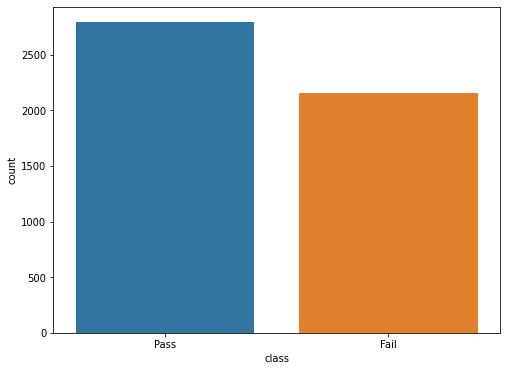

In [26]:
plt.figure(figsize=(8,6))
sns.countplot(data=final_df, x="class")

## Preprocesamiento para el modelo de red neuronal.

Se separa el dataset limpio en datos de entrada y salida.

In [27]:
X = final_df.drop(["class", "exam_score"], axis=1)
y = final_df["class"]

Los datos de entrada y salida se dividen en datos de entrenamiento y datos de validación, para evitar overfitting.

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

Se escala todos los valores de entrada para el modelo de red neuronal en el rango [0 - 1].

In [29]:
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

Funcion que convierte la clase del patron de entrenamiento de string a numero

In [30]:
def categories(cat):
    if cat=="Fail":
        return 0
    if cat=="Pass":
        return 1
    
y_test = np.asarray(list(map(categories, y_test)))
y_train = np.asarray(list(map(categories, y_train)))

## Red Neuronal Multicapa

Se define y compila el modelo

In [31]:
model1=Sequential()

model1.add(Dense(5, activation="relu"))
model1.add(Dropout(0.5))
model1.add(Dense(8, activation="relu"))
model1.add(Dense(1, activation="sigmoid"))

model1.compile(loss="binary_crossentropy", optimizer="adam",
             metrics=['accuracy'])

Entrenamiento del modelo.

In [32]:
model1.fit(x= X_train, y= y_train, epochs= 100, validation_data= (X_test,y_test))

Epoch 1/100
109/109 [==============================] - 1s 3ms/step - loss: 0.7108 - accuracy: 0.5117 - val_loss: 0.6804 - val_accuracy: 0.5717
Epoch 2/100
109/109 [==============================] - 0s 2ms/step - loss: 0.6794 - accuracy: 0.5507 - val_loss: 0.6640 - val_accuracy: 0.5899
Epoch 3/100
109/109 [==============================] - 0s 2ms/step - loss: 0.6552 - accuracy: 0.6044 - val_loss: 0.6347 - val_accuracy: 0.6741
Epoch 4/100
109/109 [==============================] - 0s 2ms/step - loss: 0.6344 - accuracy: 0.6162 - val_loss: 0.6038 - val_accuracy: 0.7172
Epoch 5/100
109/109 [==============================] - 0s 2ms/step - loss: 0.6110 - accuracy: 0.6382 - val_loss: 0.5675 - val_accuracy: 0.7535
Epoch 6/100
109/109 [==============================] - 0s 2ms/step - loss: 0.5872 - accuracy: 0.6613 - val_loss: 0.5322 - val_accuracy: 0.7798
Epoch 7/100
109/109 [==============================] - 0s 2ms/step - loss: 0.5668 - accuracy: 0.6867 - val_loss: 0.5017 - val_accuracy: 0.8000

## Resultados

Graficamos las méétricas que se utilizaron en el entrenamiento y validación del modelo.

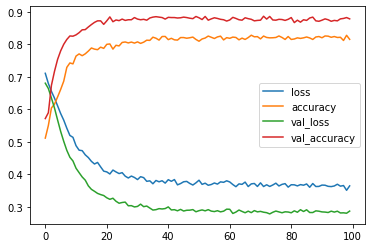

In [33]:
metrics=pd.DataFrame(model1.history.history)
metrics.plot()

Confusion Matrix

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


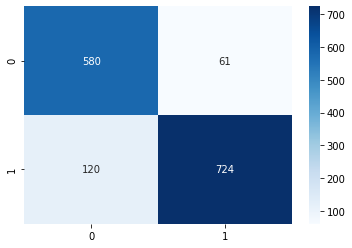

In [37]:
predictions=model1.predict_classes(X_test)
cf_matrix = confusion_matrix(y_test,predictions)

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

Precision, Recall y F1-score.

In [35]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87       641
           1       0.92      0.86      0.89       844

    accuracy                           0.88      1485
   macro avg       0.88      0.88      0.88      1485
weighted avg       0.88      0.88      0.88      1485

